In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plotter
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from xgboost import XGBClassifier

In [24]:
os.chdir('/Users/darsh/Documents/Data Science/Santander Project/Python')

In [25]:
# Load train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [26]:
# Backing up the ID variable from train and test datasets
key_train = train.ID_code
key_test = test.ID_code

In [27]:
# Droppping the ID variable from train and test datasets
train.drop(columns = 'ID_code', inplace = True)
test.drop(columns = 'ID_code', inplace = True)

train.target = train.target.astype('category')

In [ ]:
def plot_target_class(var):
    
    plotter.figure(figsize=(15,15))
    plotter.subplot(221)
    plotter.title("Count of each level of target")
    sns.countplot(x = var)

    plotter.subplot(222)
    plotter.pie(var.value_counts() , labels=[0,1] ,autopct='%1.2f%%')
    plotter.legend(['class 0','class 1'])
    plotter.title("Percentage of each level in target ")
    plotter.show()

In [ ]:
# Plotting summary of the target varaible
plot_target_class(train.target)

In [ ]:
# Checking for missing values
train.isnull().sum()
test.isnull().sum()

# No missing values in either train or tst data

In [28]:
# Splitting train dataset into dependent and independent variables
x = train.loc[:, train.columns != 'target']
y =train.target

In [ ]:
# Checking for collinearity using a heat map

f, ax = plotter.subplots(figsize = (10,10))
corr = x.corr()
sns.heatmap(corr, 
            mask = np.zeros_like(corr, dtype = np.bool),
            cmap = sns.diverging_palette(250, 15, as_cmap = True),
            square = True,
            ax = ax
           )
plotter.title('Correlation heat map for train dataset')
plotter.show()

# None of the independent variables seem to have a collinearity issue

In [76]:
# Writing a function to generate feature distribution and box plots
   
def plot(x, plottype = 'dist'):
    for i in range(0, x.shape[1], 20):
        fig = plotter.figure(figsize=(15,15))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        names =list(range(i,(i+20)))
        for j , realindex in  enumerate(names,1):
            ax = fig.add_subplot( 5,4,j)
            if( plottype != 'box'):
                sns.distplot(x.iloc[:,realindex], ax=ax, hist = False, color = '#cdcc76')
            else:
                sns.boxplot(x.iloc[:,realindex], ax=ax, color = '#cdcc76')
        if( plottype != 'box'):
            plotter.suptitle("Distribution plot for features:"+str(i)+"-"+str(i+19))
        else:
            plotter.suptitle("Box plot for features:"+str(i)+"-"+str(i+19))
        plotter.show()

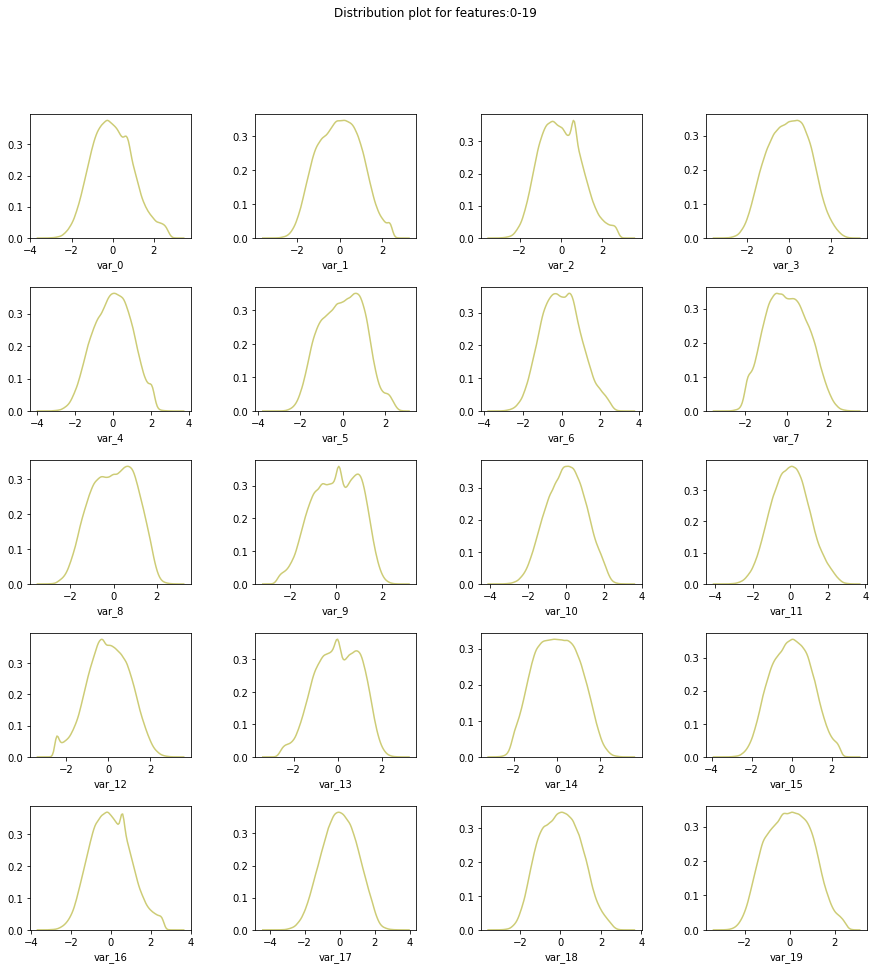

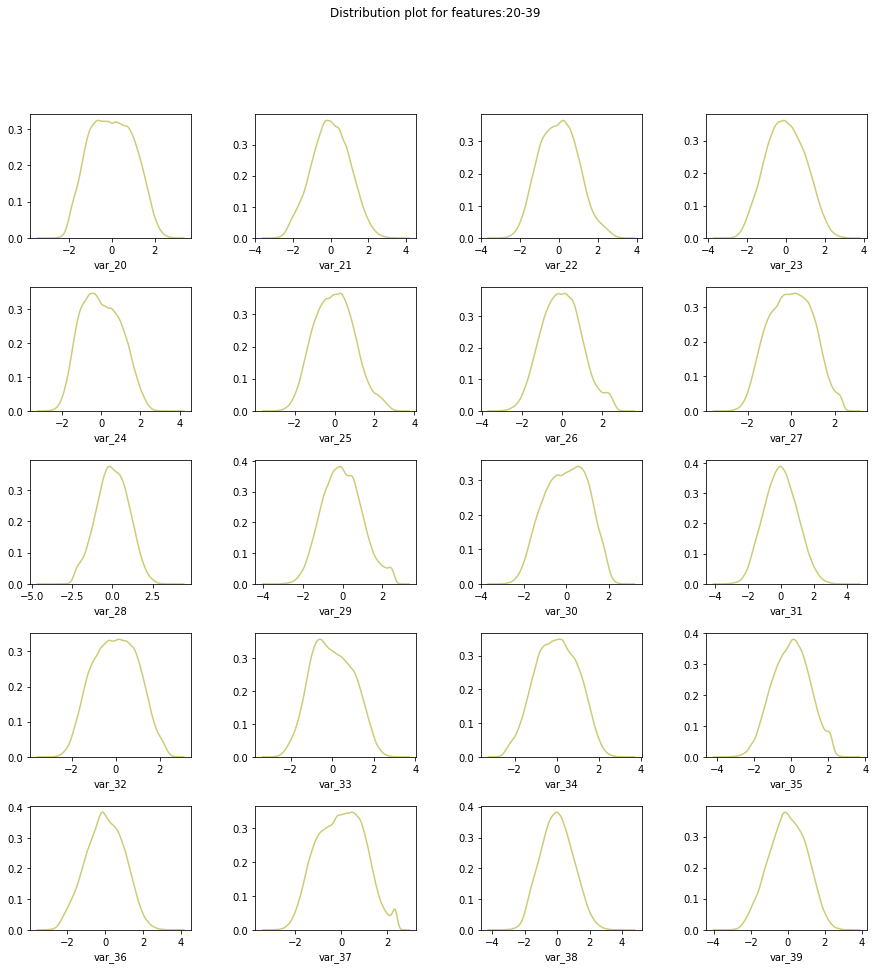

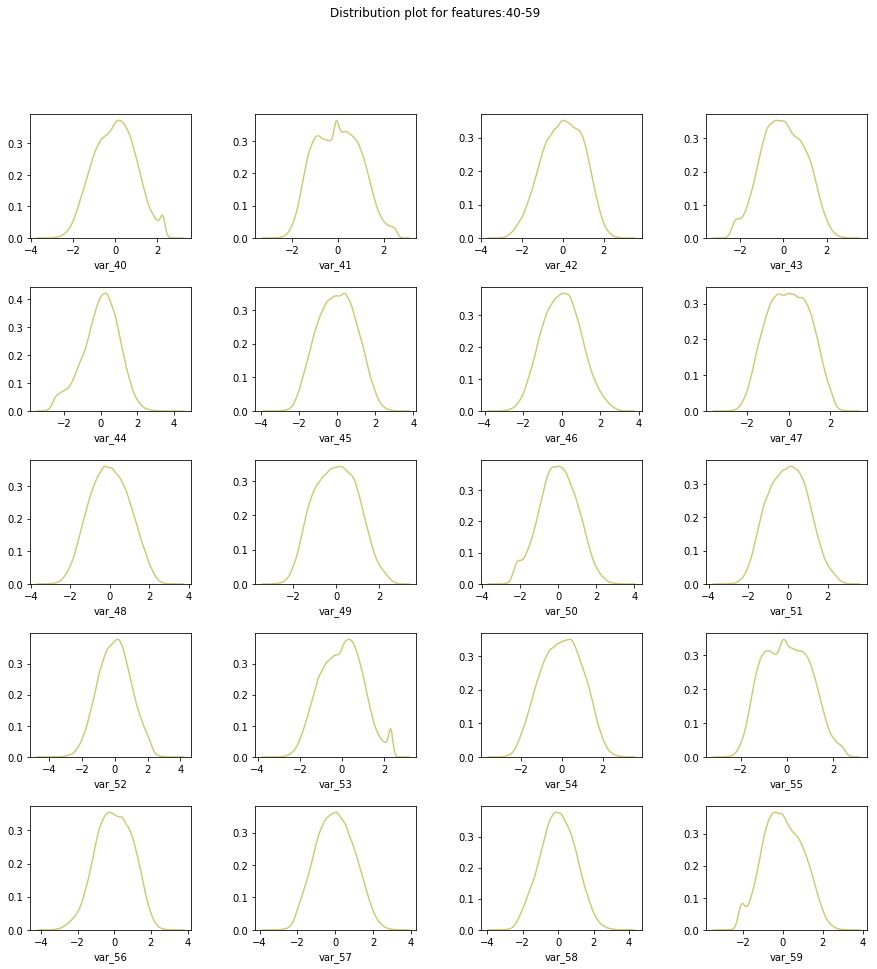

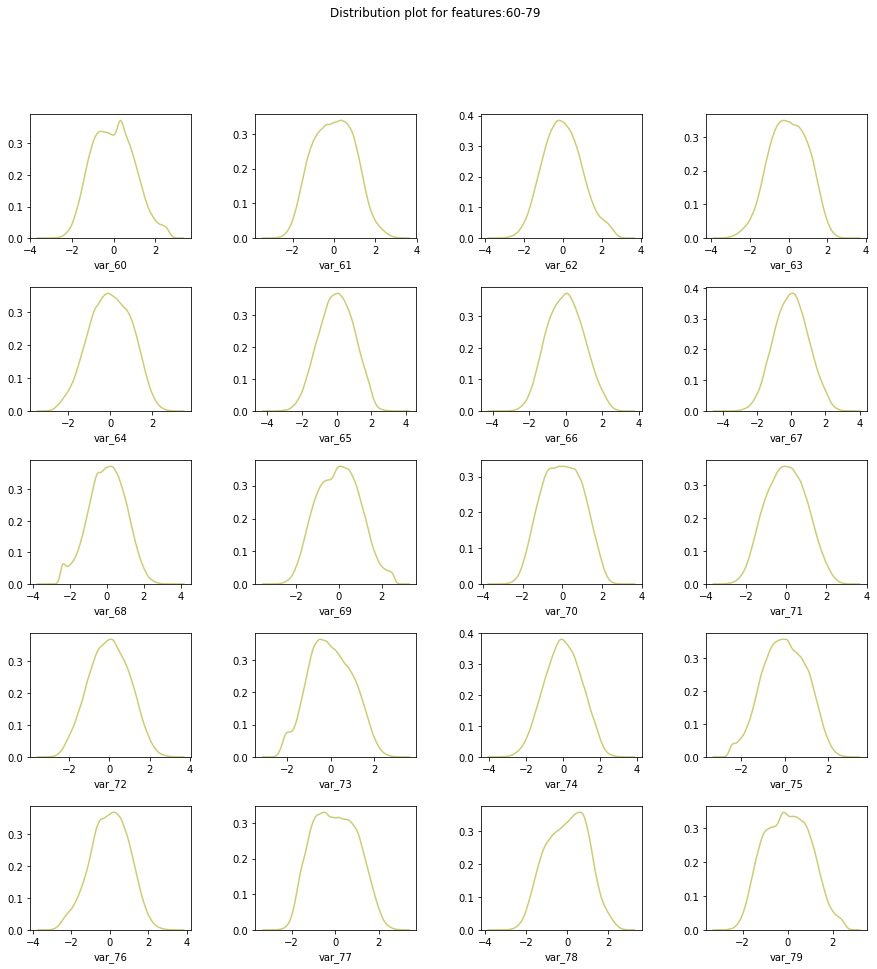

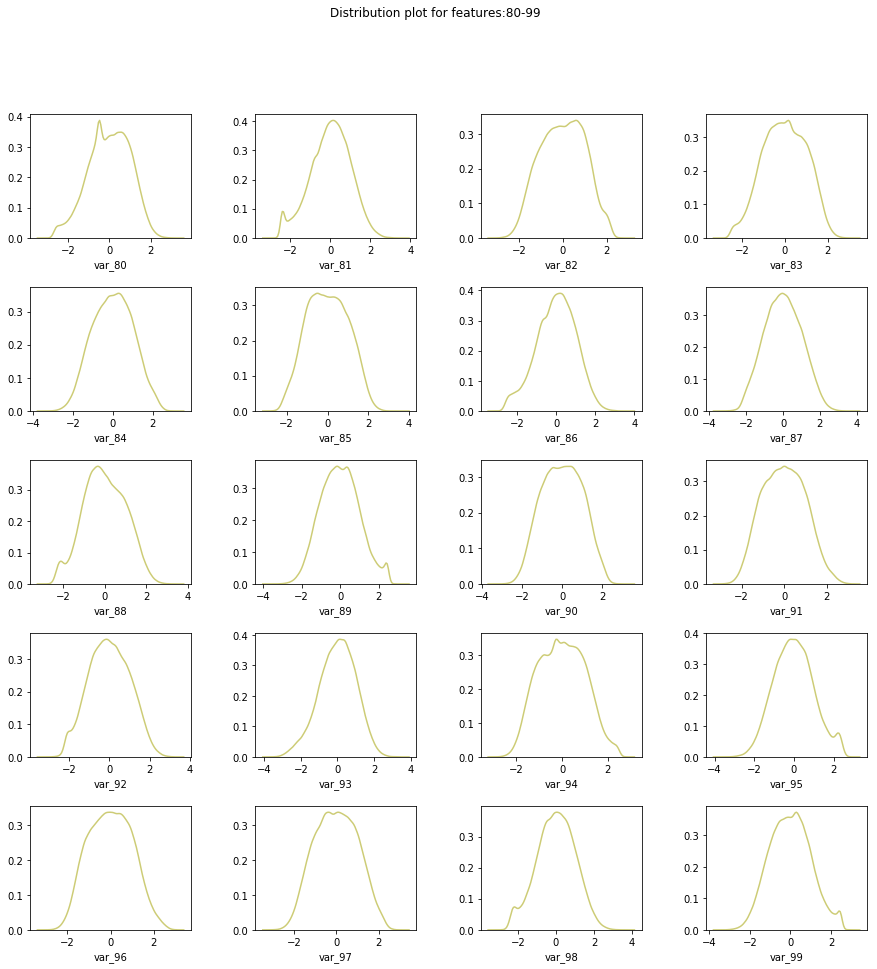

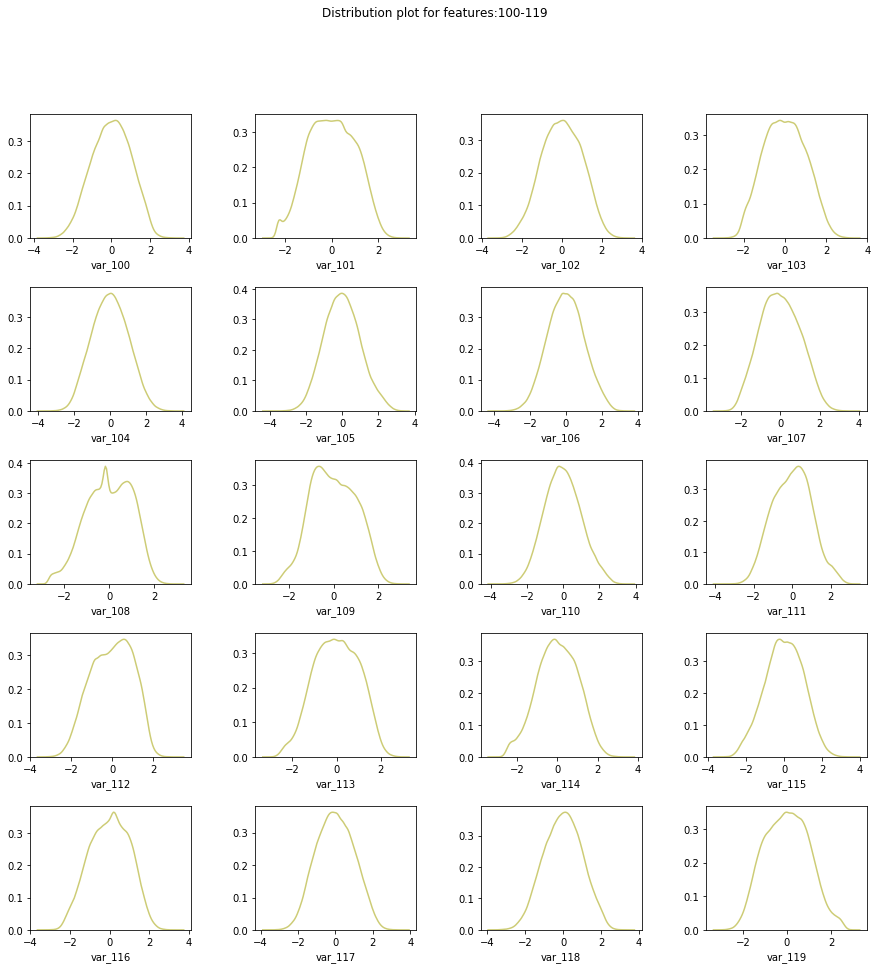

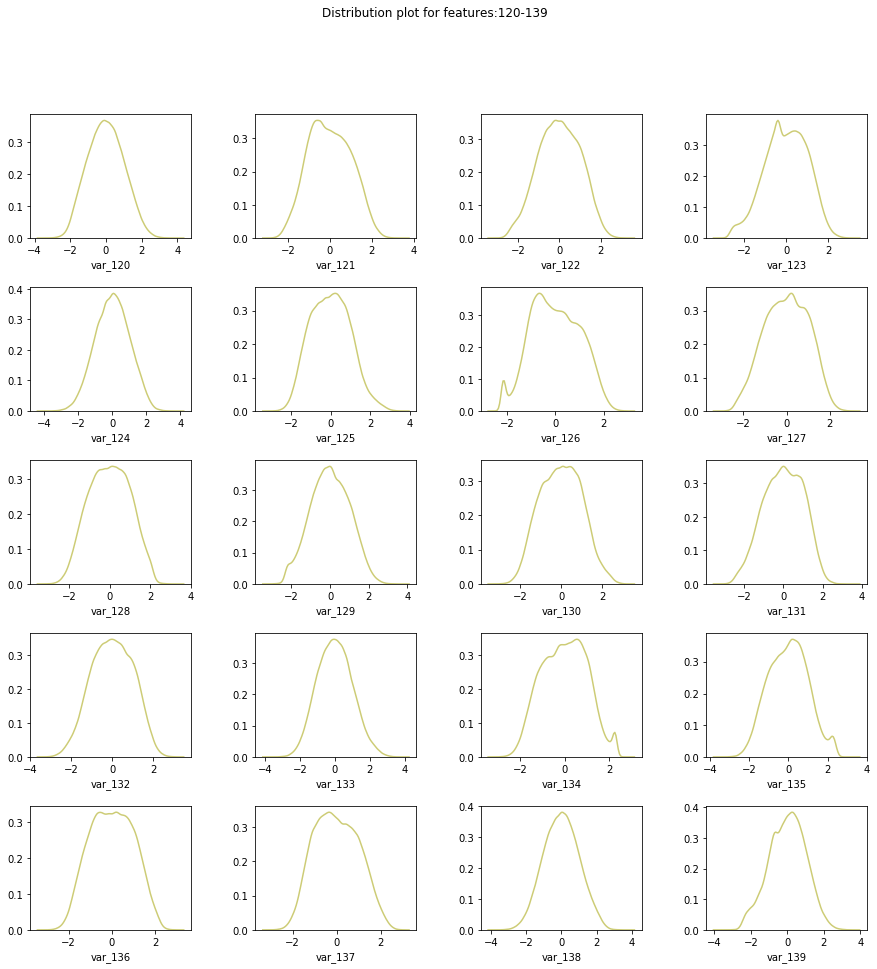

In [ ]:
plot(x)

# The independent variables do not show any abnormal distribution

In [ ]:
plot(x, 'box')

# Many of the features contain outliers. 
# Leaving them untouched since the classification is biased towards class 0
# Assuming that the positive responses may be affected by the outliers in the data

In [29]:
# Bringing all features to a single scale

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

In [30]:
# Defining a generic function to evaluate a model's metrics

def evaluate_model(model, x, y, model_name):
    prob = model.predict_proba(x)[:, 1]
    predictions = model.predict(x)
    confMatrix = pd.crosstab(y, predictions)
    print(confMatrix)
    # Calculating the metrics
    model_metrics = {}
    model_metrics['fpr'], model_metrics['tpr'], _ = metrics.roc_curve(y, prob)

    tn = confMatrix.iloc[0,0]
    tp = confMatrix.iloc[1,1]
    fp = confMatrix.iloc[0,1]
    fn = confMatrix.iloc[1,0]
    model_metrics['fnr'] = (fn * 100) / (fn + tp)

    model_metrics['precision'], model_metrics['recall'], _ = metrics.precision_recall_curve(y, prob)

    model_metrics['accuracy'] = metrics.accuracy_score(y, predictions) * 100

    model_metrics['auc'] = metrics.roc_auc_score(y, prob)

    model_metrics['prauc'] = metrics.average_precision_score(y, prob)

    plotter.figure(figsize = (10, 5))
    plotter.subplot(121)
    plotter.title("ROC Curve for" + model_name)
    plotter.plot(model_metrics['fpr'],model_metrics['tpr'],label = "auc=" + str(model_metrics['auc']))
    plotter.legend(loc=4)

    plotter.subplot(122)
    plotter.title("PRAUC Curve for" + model_name)
    plotter.plot(model_metrics['precision'],model_metrics['recall'],label="PR AUC="+str(model_metrics['prauc']))
    plotter.legend(loc=4)
    plotter.show()
    
    return model_metrics

col_0        0      1
target               
0       140864  39038
1         4433  15665


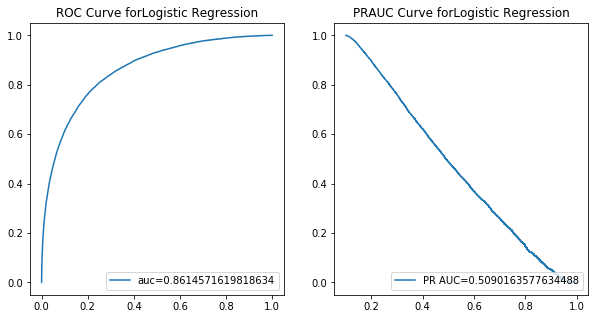

Accuracy: 78.2645% False Negative Rate: 22.056921086675292%
Precision: 25.120266730215874% Recall: 82.4122293740376%


In [45]:
# Evaluating algorithms
# Logistic regression
glm_model = LogisticRegressionCV(cv = 5, class_weight='balanced', random_state=5, solver = 'lbfgs', max_iter = 4000)
glm_model.fit(x,y)
glm_metrics = evaluate_model(glm_model, x, y, "Logistic Regression")
print("Accuracy: " + str(glm_metrics['accuracy']) + "% False Negative Rate: " + str(glm_metrics['fnr']) + "%")
print("Precision: " + str(glm_metrics['precision'].mean() * 100) + "% Recall: " + str(glm_metrics['recall'].mean() * 100) + "%")

col_0       0   1
target           
0       59367   1
1        6622  10


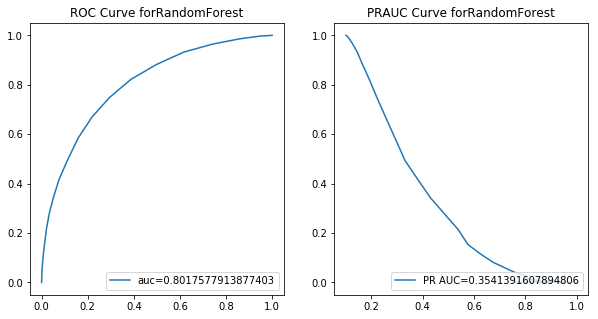

Accuracy: 89.96515151515152% False Negative Rate: 99.84921592279855%
Precision: 55.114914382280425% Recall: 34.98676991322619%


In [65]:
# Evaluating algorithms
# RandomForest

# implementing train-test-split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify = y, random_state=5)

rf_model = RandomForestClassifier(n_estimators = 50, random_state=5).fit(x_train, y_train)

rf_metrics = evaluate_model(rf_model, x_test, y_test, "RandomForest")
print("Accuracy: " + str(rf_metrics['accuracy']) + "% False Negative Rate: " + str(rf_metrics['fnr']) + "%")
print("Precision: " + str(rf_metrics['precision'].mean() * 100) + "% Recall: " + str(rf_metrics['recall'].mean() * 100) + "%")

col_0        0     1
target              
0       176957  2945
1        12716  7382


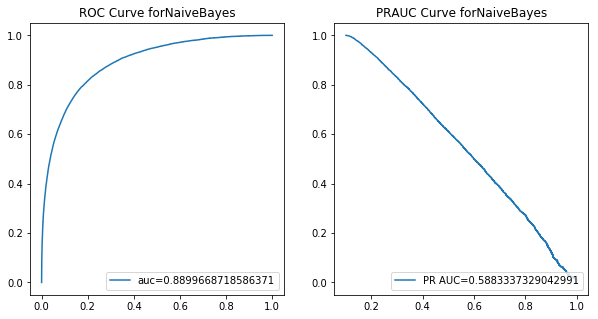

Accuracy: 92.1695% False Negative Rate: 63.269977112150464%
Precision: 26.752182556251462% Recall: 84.94798699854876%


In [71]:
# Evaluating algorithms
# NaiveBayes

nb_model = GaussianNB().fit(x,y)

nb_metrics = evaluate_model(nb_model, x, y, "NaiveBayes")
print("Accuracy: " + str(nb_metrics['accuracy']) + "% False Negative Rate: " + str(nb_metrics['fnr']) + "%")
print("Precision: " + str(nb_metrics['precision'].mean() * 100) + "% Recall: " + str(nb_metrics['recall'].mean() * 100) + "%")

In [ ]:
# Selecting logistic regression since it gives the best Accuracy to FNR ratio
test_predictions = glm_model.predict(test)

In [ ]:
# Rebuilding the test dataset
test['ID_code'] = key_test
test['target'] = test_predictions

In [ ]:
# Saving the final output to file
test.to_csv('submission - python.csv', index = False)